In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
from sklearn.model_selection import train_test_split
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes
from sklearn.utils import shuffle

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA,L_BFGS_B,ADAM
from IPython.display import clear_output
from qiskit import  execute, BasicAer

from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

In [2]:
# name='_smear0.1_MaxTran10.0_shuffle1_scaling1'
# name='_smear0.1_MaxTran10_shuffle0'
name='_smear0.1_MaxTran5.0_shuffle1_scaling1'
resultsName="results"+name


folderDir="/Users/lizhelun/Desktop/QC/VQC-Permutable-Lorentz-symmetry/"
dataDir="/Users/lizhelun/Desktop/QC/VQC-Permutable-Lorentz-symmetry/Images"


#nShots=2**13
maxIteration=500
maxEvents=300

maxEvents=200
training_results={}



with open(dataDir+"/label"+name+".pk", "rb") as fp:   #Pickling
    label=pickle.load(fp)
    
with open(dataDir+"/images"+name+".pk", "rb") as fp:   #Pickling
    images=pickle.load(fp)
    
X=images.reshape(images.shape[0],images.shape[1]*images.shape[2])
y=label







y[y==0]=-1







X,y=shuffle(X,y,random_state=1000)
train_ratio=0.6
X_train, X_valTest, y_train, y_valTest = train_test_split(X.copy(), y.copy(), train_size=train_ratio, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_valTest, y_valTest, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train=X_train/X_train.max()
X_val=X_val/X_val.max()
X_test=X_test/X_test.max()

sampler = Sampler()
print("number of training: ",y_train.shape[0])
print("number of validation: ",y_val.shape[0])
print("number of test: ",y_test.shape[0])

number of training:  1200
number of validation:  400
number of test:  400


In [3]:
def dataAugmentation(data):
    #centering
    meanValues=data.mean(axis=1)
    print(data.shape)
    print(meanValues.shape)
    data=data-meanValues[:,None,:]
    
    #scaling
    norm=np.linalg.norm(data,axis=2)
    scale=norm.max(axis=1)
    data=data/scale[:,None,None]
    
    return data

def Dot(data):
    output=[]
    

 
    for i in range(data.shape[0]):
        event=[]
        #first record dot product with itself:
        for j in range(data.shape[1]):
            event.append((data[i][j]*data[i][j]).sum())
            
        for j in range(data.shape[1]):
            for k in np.arange(j+1,data.shape[1]):
                event.append((data[i][j]*data[i][k]).sum())
        output.append(np.array(event))
    
    output=np.array(output)
    return output
    

In [4]:
X_centerScale=dataAugmentation(images).reshape(images.shape[0],images.shape[1]*images.shape[2])
y_centerScale=label

X_centerScale,y_centerScale=shuffle(X_centerScale,y_centerScale,random_state=1000)
train_ratio=0.6
X_train_centerScale, X_valTest_centerScale, y_train_centerScale, y_valTest_centerScale = train_test_split(X_centerScale.copy(), y_centerScale.copy(), train_size=train_ratio, random_state=100)
X_val_centerScale, X_test_centerScale, y_val_centerScale, y_test_centerScale = train_test_split(X_valTest_centerScale, y_valTest_centerScale, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train_centerScale=X_train_centerScale/X_train_centerScale.max()
X_val_centerScale=X_val_centerScale/X_val_centerScale.max()
X_test_centerScale=X_test_centerScale/X_test_centerScale.max()



X_augDot=Dot(dataAugmentation(images))
y_augDot=label

X_augDot,y_augDot=shuffle(X_augDot,y_augDot,random_state=400)
train_ratio=0.6
X_train_augDot, X_valTest_augDot, y_train_augDot, y_valTest_augDot = train_test_split(X_augDot.copy(), y_augDot.copy(), train_size=train_ratio, random_state=100)
X_val_augDot, X_test_augDot, y_val_augDot, y_test_augDot = train_test_split(X_valTest_augDot, y_valTest_augDot, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train_augDot=X_train_augDot/X_train_augDot.max()
X_val_augDot=X_val_augDot/X_val_augDot.max()
X_test_augDot=X_test_augDot/X_test_augDot.max()

num_qubits=X_augDot.shape[1]



(2000, 4, 2)
(2000, 2)
(2000, 4, 2)
(2000, 2)


In [5]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    print(len(objective_func_vals))
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [6]:
X_train_centerScale.shape

(1200, 8)

In [7]:
nLayer_realAmplitude=2
num_qubits=X_train_centerScale.shape[1]
n_inputParams=num_qubits
n_params=nLayer_realAmplitude*num_qubits
N_particles=4
print(num_qubits)


8


In [8]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)


qc.compose(feature_map, inplace=True) 
qc.compose(ansatz,inplace=True)    


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


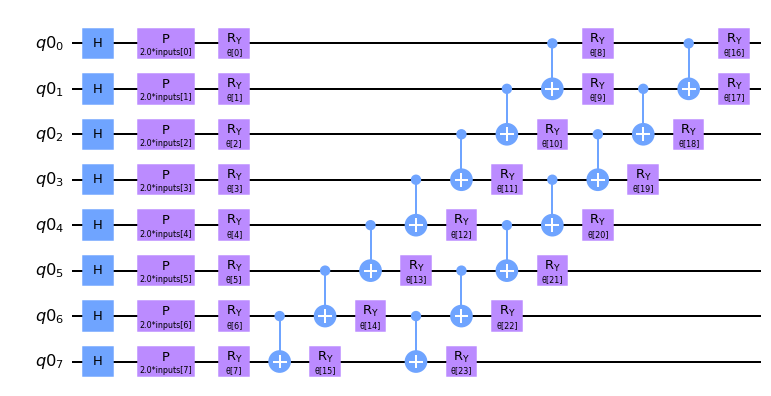

In [9]:
qc.decompose().draw('mpl')

In [10]:
zeroState = '0'
for i in range(num_qubits-1):
    zeroState+='0'
def countZero(x):
    return f"{bin(x)}".count("0")%(num_qubits+1)

observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])

In [11]:
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=ansatz.parameters
)


In [12]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [13]:
estimator_classifier_baseline = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=300), callback=callback_graph
)



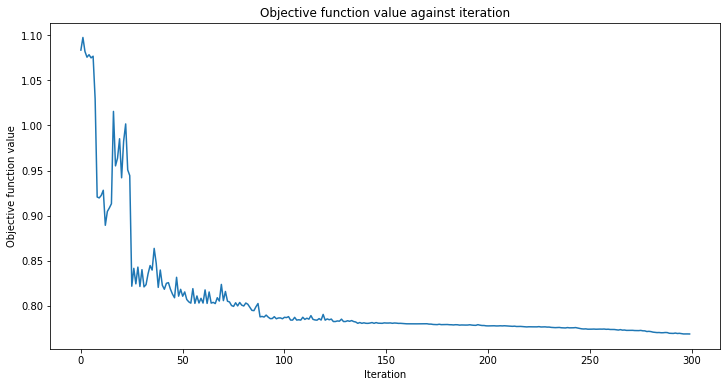

training score =  0.72
test score =  0.755


In [14]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_baseline.fit(X_train_centerScale[0:maxEvents], y_train_centerScale[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)

# score classifier
print("training score = ",estimator_classifier_baseline.score(X_train_centerScale[0:maxEvents], y_train_centerScale[0:maxEvents]))
print("test score = ",estimator_classifier_baseline.score(X_test_centerScale[0:maxEvents], y_test_centerScale[0:maxEvents]))


In [15]:
print("training score = ",estimator_classifier_baseline.score(X_train_centerScale[0:maxEvents], y_train_centerScale[0:maxEvents]))
print("test score = ",estimator_classifier_baseline.score(X_test_centerScale[0:maxEvents], y_test_centerScale[0:maxEvents]))


training score =  0.72
test score =  0.755


In [16]:
objective_func_vals_baseline=objective_func_vals

In [17]:
n_inputParams=num_qubits
n_params=num_layers*nLayer_realAmplitude
N_particles=4
num_qubits=int((N_particles+1)*N_particles/2)

In [19]:
qr_rot = QuantumRegister(num_qubits)
qc_rot = QuantumCircuit(qr_rot)
feature_map_rot = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz_rot=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)


inputParams_index=0
params_index=0


qc_rot.compose(feature_map_rot, inplace=True) 
qc_rot.compose(ansatz_rot,inplace=True)    


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


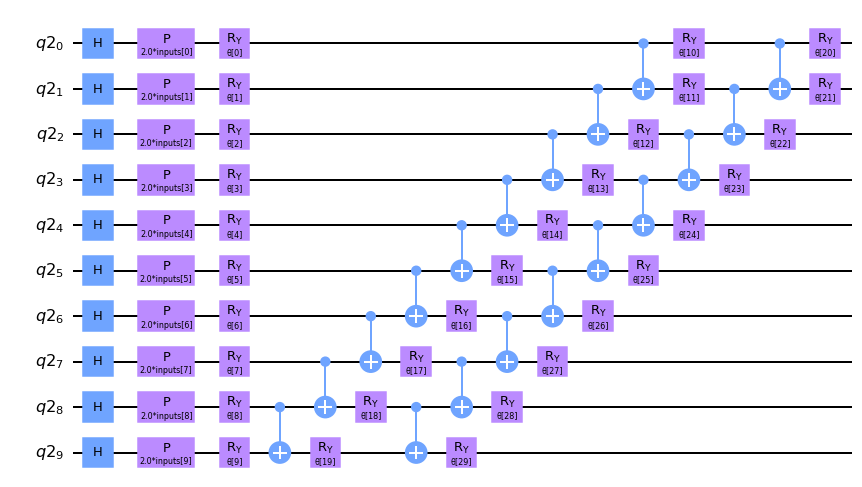

In [20]:
qc_rot.decompose().draw('mpl')

In [21]:
zeroState = '0'
for i in range(num_qubits-1):
    zeroState+='0'
def countZero(x):
    return f"{bin(x)}".count("0")%(num_qubits+1)

observable1_rot = SparsePauliOp.from_list([("Z" * num_qubits, 1)])

In [22]:
estimator_qnn_rot = EstimatorQNN(
    circuit=qc_rot, observables=observable1_rot, input_params=feature_map_rot.parameters, weight_params=ansatz_rot.parameters
)


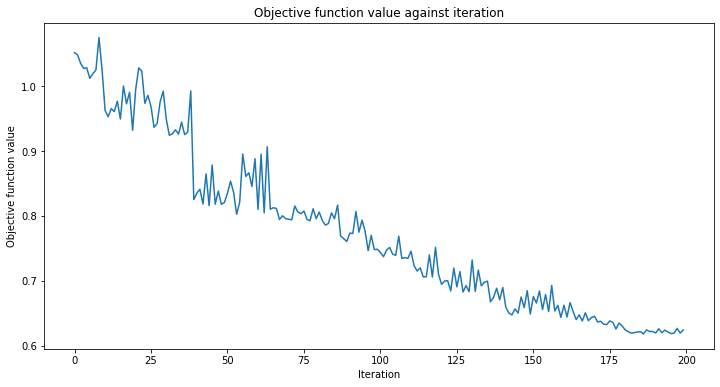

training score =  0.965
test score =  0.97


In [23]:
estimator_classifier_rot = NeuralNetworkClassifier(
    estimator_qnn_rot, optimizer=COBYLA(maxiter=200), callback=callback_graph
)


objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_rot.fit(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)

# score classifier
print("training score = ",estimator_classifier_rot.score(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents]))
print("test score = ",estimator_classifier_rot.score(X_test_augDot[0:maxEvents], y_test_augDot[0:maxEvents]))


In [24]:
estimator_classifier_rot.score(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])

0.965

In [25]:
estimator_classifier_rot.score(X_test_augDot, y_test_augDot)

0.9625

In [26]:
objective_func_vals_rot=objective_func_vals

In [27]:
num_layers=2
n_inputParams=num_qubits
n_params=num_layers*4
N_particles=4
num_qubits=int((N_particles+1)*N_particles/2)

In [28]:
qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")


weights = ParameterVector("weight", n_params)
print(f"weight parameters: {[str(item) for item in weights.params]}")

inputParams_index=0
params_index=0


qc.compose(feature_map, inplace=True) 
   
for layer in range(num_layers):
    
        for i in range(N_particles):
            qc.ry(weights[params_index],i)
            
        params_index += 1 
        
        for i in range(N_particles):
            for k in np.arange(i,N_particles,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
            
            
        params_index += 1
        for j in np.arange(N_particles,num_qubits,1):
            qc.ry(weights[params_index],j)
        params_index += 1
        
        for i in np.arange(N_particles,num_qubits,1):
            for k in np.arange(i,num_qubits,1):
                if i!=k:
                    qc.rzz(weights[params_index],i,k)
                    
        params_index += 1
            
        
        qc.barrier()

weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]', 'weight[4]', 'weight[5]', 'weight[6]', 'weight[7]']


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


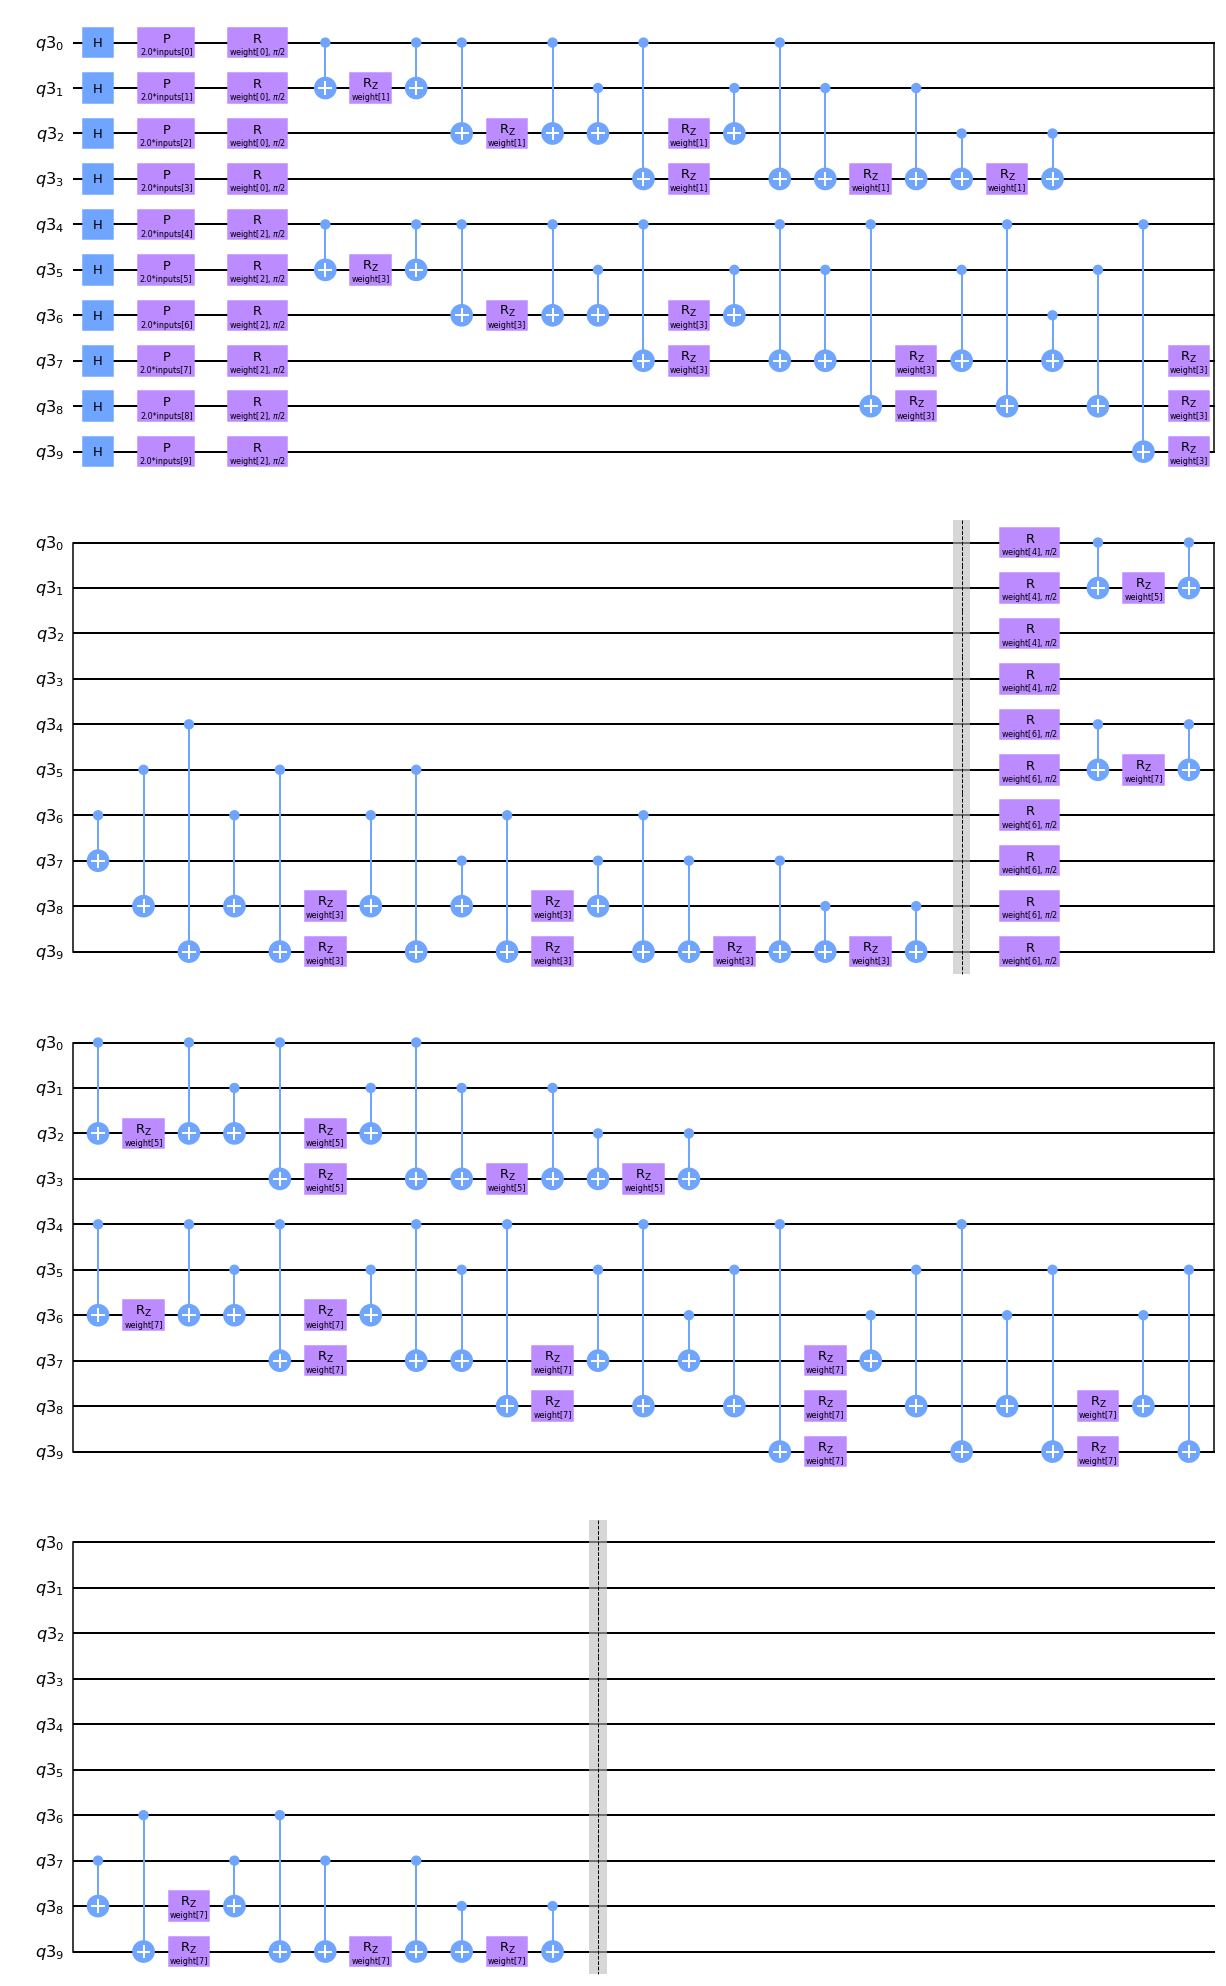

In [29]:
qc.decompose().draw('mpl')

In [30]:
observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
)

In [31]:
index=10
shuffled=shuffle(images[index],random_state=np.random.randint(100))[None,:]
dot1=Dot(images[index:index+1])
dot2=Dot(shuffled)

estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)
out1=estimator_qnn.forward(dot1, estimator_qnn_weights)
out2=estimator_qnn.forward(dot2, estimator_qnn_weights)
print(out1)
print(out2)

[[-0.00180233]]
[[-0.00180233]]


In [32]:
estimator_classifier_rotPerm = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=200), callback=callback_graph
)

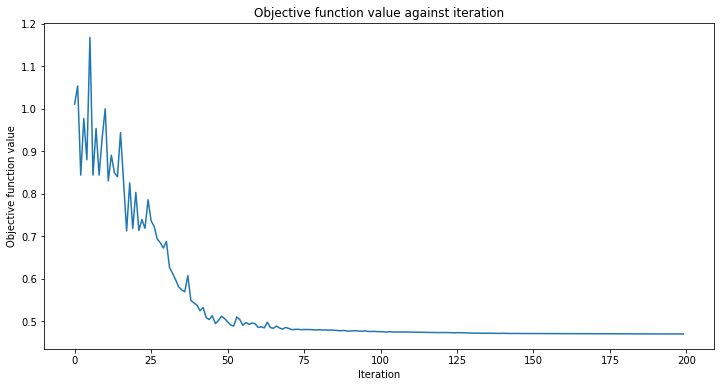

1.0

In [33]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier_rotPerm.fit(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])

# return to default figsize
# plt.rcParams["figure.figxsize"] = (6, 4)

# score classifier
estimator_classifier_rotPerm.score(X_test_augDot[0:maxEvents], y_test_augDot[0:maxEvents])

In [34]:
objective_func_vals_rotPerm=objective_func_vals

In [35]:
estimator_classifier_rotPerm.score(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])

1.0

In [36]:
estimator_classifier_rotPerm.score(X_test_augDot, y_test_augDot)

1.0

In [37]:
estimator_classifier_baseline.neural_network.num_weights

24

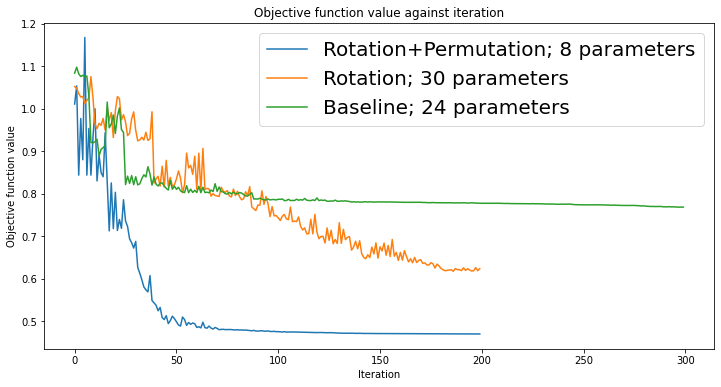

In [38]:
plt.figure(1)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals_rotPerm)), objective_func_vals_rotPerm,label='Rotation+Permutation; {} parameters'.format(estimator_classifier_rotPerm.neural_network.num_weights))
plt.plot(range(len(objective_func_vals_rot)), objective_func_vals_rot,label='Rotation; {} parameters'.format(estimator_classifier_rot.neural_network.num_weights))
plt.plot(range(len(objective_func_vals_baseline)), objective_func_vals_baseline,label='Baseline; {} parameters'.format(estimator_classifier_baseline.neural_network.num_weights))
plt.legend(fontsize=20)
plt.savefig("training comparison")
plt.show()